# Notebook for Exploring Explainable AI in a Physics Setting

In this notebook we explore how SHAP explainability deals with a physical system like the Duffing Oscillator

In [1]:
"""
Import Libraries
"""
# General Libraries
import numpy as np
import pandas as pd
import os

# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns

# Explainability
import lime
import shap

# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [2]:
"""
Choose the training data set to be trained on.

For general datasets use custom suffix.
"""
suffix = "mac_lots"#"delta03_irrelevant"#"delayed_traj_delta03"

train = True

X_train = pd.read_csv("Data/X_train_"+suffix+".csv", header=0, index_col=0)
y_train = pd.read_csv("Data/y_train_"+suffix+".csv", header=0, index_col=0)
X_test = pd.read_csv("Data/X_test_"+suffix+".csv", header=0, index_col=0)
y_test = pd.read_csv("Data/y_test_"+suffix+".csv", header=0, index_col=0)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
"""
f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = y_test.iloc[:10000,:], x = 'xt', y='vt', ax=axs, marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/data_only_"+suffix+".svg", dpi='figure')

f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = X_test.iloc[:10000,:], x = 'x0', y='v0', ax=axs, marker='x', linewidth = 1)
axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/data_only_"+suffix+".svg", dpi='figure')
"""

'\nf, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))\n\nsns.scatterplot(data = y_test.iloc[:10000,:], x = \'xt\', y=\'vt\', ax=axs, marker=\'x\', linewidth = 1)\n\naxs.set(xlim=(-2, 2), ylim=(-2, 2))\naxs.set_xlabel(\'x [ ]\')\naxs.set_ylabel(\'v [ ]\')\naxs.set_title("Phase Space Plot")\n\nf.tight_layout()\n\nf.savefig("Images/data_only_"+suffix+".svg", dpi=\'figure\')\n\nf, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))\n\nsns.scatterplot(data = X_test.iloc[:10000,:], x = \'x0\', y=\'v0\', ax=axs, marker=\'x\', linewidth = 1)\naxs.set(xlim=(-2, 2), ylim=(-2, 2))\naxs.set_xlabel(\'x [ ]\')\naxs.set_ylabel(\'v [ ]\')\naxs.set_title("Phase Space Plot")\n\nf.tight_layout()\n\nf.savefig("Images/data_only_"+suffix+".svg", dpi=\'figure\')\n'

## Preprocess

Optional data preprocessing step, fourier transform.

Scale the data to 0 mean and unit variance, this is mainly done to improve the neural network's performance but also ensures that magnitude differences between the features have no impact on explainability.

In [4]:
"""
from scipy.fft import fft, fftfreq, fftshift


fft(X_test.values)

t = np.arange(250)

sp = fftshift(fft(X_test.values[:250,:]))

freq = fftshift(fftfreq(t.shape[-1]))

plt.plot(freq, sp.real, freq, sp.imag, 'x')

plt.show()
"""

"\nfrom scipy.fft import fft, fftfreq, fftshift\n\n\nfft(X_test.values)\n\nt = np.arange(250)\n\nsp = fftshift(fft(X_test.values[:250,:]))\n\nfreq = fftshift(fftfreq(t.shape[-1]))\n\nplt.plot(freq, sp.real, freq, sp.imag, 'x')\n\nplt.show()\n"

In [5]:
scaler = StandardScaler()

scaler.fit(X_train.values)
scaler.transform(X_train.values, copy=False)
scaler.transform(X_test.values, copy = False)

#anova_svm = make_pipeline(scaler, model)
#anova_svm.fit(X_train, y_train)

array([[-1.46476691, -0.15646806, -0.52950641],
       [-1.08962127,  0.54608022, -0.12767396],
       [ 0.42444954,  0.3075383 , -0.18309912],
       ...,
       [-0.19980822, -1.30346423,  0.37115253],
       [ 1.55915821,  1.11694855,  1.56972175],
       [ 1.43625866,  1.60450129, -1.52023125]])

## Network Training

Here we set up the neural network. We are using a large batch size (5096) to speed up training. Data are shuffled before training because we are using a method to generate the data that causes codependence in adjacent training samples as they belong to the same trajectory. Early stopping criteria are there to stop overfitting though this has rarely been a problem in this setting.

The network architecture makes use of a lot of dense (fully connected) layers. This leads to a large number of trainable parameters so care should be taken to ensure that the dataset is large enough to prevent overfitting being a viable strategy.

As a validation set we use 20% of the training data.

We make use of the Adam optimiser. Using a learning rate of 0.001 seems to work, greater learning rates cause the network to not learn at all and a smaller learning rate slows learning unnecessarily.

In [6]:
"""
Define and Create Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model

# Create a basic model instance
model = MLModel()

In [7]:
# Model Weights Path
checkpoint_path = "Networks/training"+suffix+"cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [8]:
"""
Train Model
"""
#model.build()
# Display the model's architecture
#model.summary()


if train:
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    callbacks = [cp_callback,
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
                 tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)]

    pipe = make_pipeline(scaler, model)

    history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=500, 
                      validation_split=0.2, batch_size=20364, shuffle=True, callbacks=callbacks, verbose=1)

    loss = model.evaluate(X_test, y_test, verbose=1)
    print("Trained model, loss: {:5.2f}%".format(loss))

Epoch 1/500
393/393 [==============================] - 51s 128ms/step - loss: 0.3915 - val_loss: 0.3427

Epoch 00001: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 2/500
393/393 [==============================] - 52s 132ms/step - loss: 0.2825 - val_loss: 0.2545

Epoch 00002: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 3/500
393/393 [==============================] - 50s 128ms/step - loss: 0.2369 - val_loss: 0.2115

Epoch 00003: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 4/500
393/393 [==============================] - 51s 130ms/step - loss: 0.2135 - val_loss: 0.2061

Epoch 00004: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 5/500
393/393 [==============================] - 52s 131ms/step - loss: 0.1995 - val_loss: 0.1923

Epoch 00005: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 6/500
393/393 [==============================] - 51s 131ms/step - loss: 0.1909 - val_loss: 0.1853

Epoch 00006: saving model to Networks\trainingmac_lotsc


Epoch 00049: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 50/500
393/393 [==============================] - 51s 129ms/step - loss: 0.1353 - val_loss: 0.1341

Epoch 00050: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 51/500
393/393 [==============================] - 50s 127ms/step - loss: 0.1351 - val_loss: 0.1375

Epoch 00051: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 52/500
393/393 [==============================] - 50s 127ms/step - loss: 0.1341 - val_loss: 0.1313

Epoch 00052: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 53/500
393/393 [==============================] - 50s 126ms/step - loss: 0.1339 - val_loss: 0.1376

Epoch 00053: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 54/500
393/393 [==============================] - 50s 126ms/step - loss: 0.1333 - val_loss: 0.1325

Epoch 00054: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 55/500
393/393 [==============================] - 51s 129ms/step - loss: 0.1335 - val

393/393 [==============================] - 50s 127ms/step - loss: 0.1154 - val_loss: 0.1105

Epoch 00146: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 147/500
393/393 [==============================] - 50s 128ms/step - loss: 0.1148 - val_loss: 0.1157

Epoch 00147: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 148/500
393/393 [==============================] - 51s 129ms/step - loss: 0.1147 - val_loss: 0.1132

Epoch 00148: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 149/500
393/393 [==============================] - 51s 129ms/step - loss: 0.1147 - val_loss: 0.1119

Epoch 00149: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 150/500
393/393 [==============================] - 50s 128ms/step - loss: 0.1146 - val_loss: 0.1171

Epoch 00150: saving model to Networks\trainingmac_lotscp1.ckpt
Epoch 151/500
393/393 [==============================] - 50s 128ms/step - loss: 0.1146 - val_loss: 0.1137

Epoch 00151: saving model to Networks\trainingmac_lotscp1

In [9]:
"""
Load Model
"""
if not train:
    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=2)
    print("Untrained model, loss: {:5.2f}%".format(loss))

    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=1)
    print("Trained model, loss: {:5.2f}%".format(loss))

In [ ]:
class TrueModel():
    """
    Class to represent the True Model of the Duffing oscillator.
    Uses the scipy odeint integrator to perform time evolution.
    """
    def __init__(self, scaler, X):
        """
            Intialise Model

            Inputs
            --------
            scaler : sklearn.preprocessing.Standardscaler object that has already been trained
            X : pd.DataFrame with columns giving the features
        """
        self.alpha=-1
        self.beta=1
        self.delta=0.3
        self.gamma=0.37
        self.omega=1.2
        self.scaler = scaler
        self.cols = X.columns
        
    def eom(self, u, t):
        """
            Equation of Motion for the Duffing Oscillator

            Inputs
            --------
            u : vector of floats, x, v
            t : float, time t

        """
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X):
        """
            Calculates the temporal evolution of [X['x0'], X['v0']] to time X['t'].

            Inputs
            --------
            X : pandas DataFrame with at least columns x0,v0,t

            Returns
            --------
            y : pandas.DataFrame with columns xt,vt
        """
        X = pd.DataFrame(self.scaler.inverse_transform(X), columns=self.cols)
        y = np.ones((np.shape(X)[0], 2))
        for i in range(0,np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i], 500, endpoint=False)
            y[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
        return y

## Evaluation and Visualisation of Results:

To be able to visualise the error we remove outliers (top 5% of absolute error). This ensures that the rare misclassifications don't drag the x-axis of our error plot out too far.



In [11]:
# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(X_test), columns=['xt','vt'])

pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y_test[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


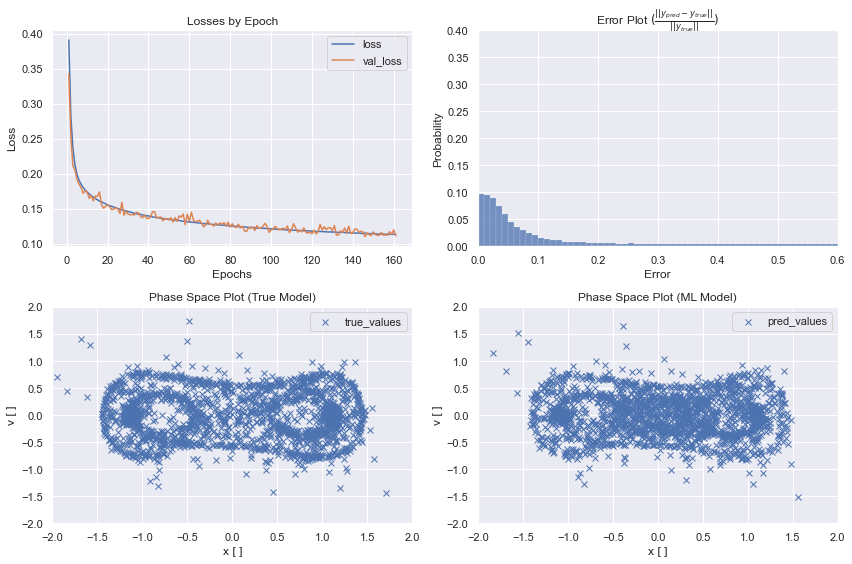

In [12]:
# Loss Plot ML Model
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.lineplot(data = history.history, x = epochs, y='loss',ax=axs[0,0], label='loss')
sns.lineplot(data = history.history, x = epochs, y='val_loss',ax=axs[0,0], label='val_loss')

axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("Losses by Epoch")
axs[0,0].legend()

# Error Plot for ML Predictions
sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.01, ax=axs[0,1])

axs[0,1].set(xlim=(0, 0.6), ylim=(0, 0.4))
axs[0,1].set_xlabel('Error')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")

# True Values Plot
sns.scatterplot(data = y_test.iloc[:2000,:], x = 'xt', y='vt',ax=axs[1,0],label='true_values', marker='x', linewidth = 1)

axs[1,0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,0].set_xlabel('x [ ]')
axs[1,0].set_ylabel('v [ ]')
axs[1,0].set_title("Phase Space Plot (True Model)")

# ML Values Plot
sns.scatterplot(data = y_pred.iloc[:2000,:], x='xt', y='vt',ax=axs[1,1],label='pred_values',  marker='x', linewidth = 1)

axs[1,1].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,1].set_xlabel('x [ ]')
axs[1,1].set_ylabel('v [ ]')
axs[1,1].set_title("Phase Space Plot (ML Model)")

f.tight_layout()

f.savefig("Images/model_summary"+suffix+".svg", dpi='figure')

### Ordered 

Lets choose a spectrum of values that have similar v0 and t whilst x0 varies from -2 to 2:


## Good Values
Only looking at good predictions: $|y_{pred}-y_{true}| < 0.1$

In [272]:
class AnalyticExplainer():
    """
        Pretty Brute force numerical gradient calculation for
        explainability of a known function
    """
    def __init__(self, f, features, labels,  h=0.01):
        """
            Initialises with some configurations for the gradient calculation
            as well as the function being differentiated.
            
            Inputs
            --------
            f : function that takes a pandas.DataFrame and outputs a 2d np.array.
            features : list of features in the pd.DataFrame for which we are to 
                differentiate f.
            labels : list of features in the np.array.
        """
        self.f = f
        self.features = features
        self.labels = labels
        self.h = h
        
    def gradient(self, X_val, feature):
        """
            Numerical Gradient Calculation by way of a CFD method.
            Inputs
            --------
            X_val : pandas.DataFrame with columns: features and values at
                which we want to take the numerical gradient.
            feature : feature by which we want to differentiate.
        """
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    def feature_att(self, X):
        """
            Calculates the Gradients for all Entries in X, for each
            feature and label combination.
            
            Inputs
            --------
            X : pandas.DataFrame with columns:features and values at
                which we want to differentiate.
            Returns
            --------
            self.__atts : [np.array[...],np.array[...]] of gradients at
                each of the input points. Calculated for each label and stacked.
        """
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            if first_run:
                self.__atts = grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                        
        return self.__atts
    


In [273]:
class wilke_explainer():
    """
        Class to evaluate models and plot both the individual and aggregate 
        feature importance. Implements a method for shap and for lime.
        Implements methods from the SHAP library, tailored for this notebook.
    """
    def __init__(self, models, background_data, test_data, test_labels, data_tol=0.1, num_vals=100, 
                 explainer_type='shap', background_resolution=100, tolerance=0.1):
        """
            Initialises the explainer objects for the various models.
            
            Parameters
            ----------
            models : dictionary of models that implement a predict function
                that take a 2d numpy.array or pandas.DataFrame
                
            background_data : pandas.DataFrame with samples of training data,
                used to create a masker for the explainer objects
                
            test_data : pandas.DataFrame with samples of test data,
                used to choose samples on which to evaluate the explainers.
                
            test_labels : pandas.DataFrame with samples of test labels,
                used to choose good samples on which to evaluate the explainers.
                
            data_tol : float, thickness of band in which data_points are considered 
                to be close to the mean value.
                
            num_vals : int, maximum number of values on which the explainers are
                evaluated.
                
            explainer_type : str, 'shap' or 'lime', decides which explainer is being
                implemented: shap.KernelExplainer or shap.LimeTabular.
                
            background_resolution : int, number of samples of the background_data to
                be used to create the masker for the explainers.
                
            tolerance : float, determines how close a model prediction must be to the
                true value for it to be considered a good estimate.

        """
        self.num_vals = num_vals
        self.tol = data_tol
        self.models = models
        self.background_data = background_data
        self.test_data = test_data
        self.test_labels = test_labels
        self.tolerance = tolerance
        self.explainers = {}
        self.background = shap.sample(self.background_data, background_resolution)
        self.explainer_type = explainer_type
        if explainer_type=='shap':
             for mod in models:
                self.explainers[mod] = shap.KernelExplainer((models[mod]).predict, self.background)
        if explainer_type=='lime':
             for mod in models:
                self.explainers[mod] = shap.other.LimeTabular((models[mod]).predict, 
                                                                     self.background, mode="regression")
                
        if explainer_type=='analytic':
            for mod in models:
                self.explainers[mod] = AnalyticExplainer(models[mod].predict, test_data.columns, test_labels.columns)
    
    def choose_data(self, i, feature, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((self.models['ml']).predict(self.test_data), axis=1) - 
                      np.linalg.norm(self.test_labels, axis=1))
        data_arr = self.test_data.iloc[np.where(vals < self.tolerance)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        data_arr = data_arr.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([self.num_vals, data_arr.shape[0]]), replace=False))]
        return data_arr
        
    def eval_explainer(self):
        """
            Evaluates the explainers on data chosen by the choose_data function.
            
            Returns
            ---------
            feature_attributions : pandas.DataFrame, array of the feature attributions
                with a multiindex (index, feature, contribution, model)
        """
        first_run = True
        for i, __feature in enumerate(self.test_data.columns):
            arr = self.choose_data(i, __feature, len(self.test_data.columns))
            for __explainer in self.explainers:
                if self.explainer_type=='shap':
                    __atts = self.explainers[__explainer].shap_values(arr)
                    print(__atts)
                if self.explainer_type=='lime':
                    __atts = self.explainers[__explainer].attributions(arr)
                    
                if self.explainer_type=='analytic':
                    __atts = self.explainers[__explainer].feature_att(arr)
                    
                for j, __contribution in enumerate(self.test_labels.columns):
                    multi_index = [range(len(arr)), [__feature for i in range(len(arr))], 
                                   [__contribution for i in range(len(arr))],
                                   [__explainer for i in range(len(arr))]]
                    if first_run:
                        self.feature_attributions = pd.DataFrame(__atts[j], 
                                                                 columns = self.test_data.columns, 
                                                                 index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('num', 'feature', 'contribution', 'model')))
                    else:
                        self.feature_attributions = self.feature_attributions.append(pd.DataFrame(__atts[j], 
                                                                 columns = self.test_data.columns, 
                                                                 index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('num', 'feature', 'contribution', 'model'))))
                    first_run = False
                    
        return self.feature_attributions
        
    def exp_plot(self):
        """
            Plotting routine to visualise the explainers' results. Plots individual
            feature contribution for each model and each feature.
        """
        f, axs = plt.subplots(self.test_labels.shape[1], self.test_data.shape[1], 
                              figsize=(4*self.test_data.shape[1], 8), 
                              gridspec_kw=dict(width_ratios=4*np.ones((self.test_data.shape[1]))))

        for i, __feature in enumerate(self.test_data.columns):
            for j, __contribution in enumerate(self.test_labels.columns):
                for __model in self.models:
                    sns.scatterplot(data = self.feature_attributions.xs((__feature, __contribution, __model), 
                                                      level=('feature', 'contribution', 'model')), 
                                    x = self.feature_attributions.xs((__feature, __contribution, 'true'), 
                                                   level=('feature', 'contribution', 'model')).index,
                                    y = self.feature_attributions.xs((__feature, __contribution, __model), 
                                                 level=('feature', 'contribution', 'model'))[__feature],
                                    label = __model, ax=axs[j,i])  
                    
                axs[j,i].set_title(r"Feature Contribution of "+__feature+" to "+__contribution+"")
                axs[j,i].set_xlabel('Index [ ]')
                axs[j,i].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()

        f.savefig("Images/"+self.explainer_type+"_summary"+suffix+"_kernel_good.svg", dpi='figure')
    
    def agg_func(self, X):
        """
            Function by which data aggregation is performed.
        
            Inputs
            -------
            X : numpy.array, array of values for which the aggregation is performed.
                Is a list of the values for a single feature, single contribution
                and single model.
                
            Returns
            -------
            y : value of the aggregation f(X).
        """
        return np.mean(np.abs(X))
    
    def aggregate(self):
        """
            Performs data aggregation. Aggregates for each feature its contribution to
            each output variable for a given model.
            
            Returns
            -------
            agg_vals : pandas.DataFrame, aggregated feature importance.
        """
        first_run = True
        
        for i, __contribution in enumerate(self.test_labels.columns):
            for j, __model in enumerate(self.models):
                for k, __feature in enumerate(self.test_data.columns):
                    
                    multi_index = [[__feature], [__contribution], [__model]]
                    if first_run:
                        self.agg_vals = pd.DataFrame(self.agg_func(
                            self.feature_attributions.xs((__feature,
                                                          __contribution,
                                                          __model), 
                                                         level=('feature', 'contribution', 'model'))[__feature].values),
                                                     columns = ['contrib'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'contribution', 'model')))
                    else:
                        self.agg_vals = self.agg_vals.append(pd.DataFrame(self.agg_func(
                            self.feature_attributions.xs((__feature,
                                                          __contribution,
                                                          __model), 
                                                         level=('feature', 'contribution', 'model'))[__feature].values),
                                                     columns = ['contrib'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'contribution', 'model'))))
                    first_run = False
                    
                    
        return self.agg_vals
    
    def agg_plot(self):
        """
            Plotting routine to visualise the aggregated feature importance.
        """
        f, axs = plt.subplots(len(self.models), self.test_labels.shape[1], 
                              figsize=(6*self.test_labels.shape[1], 4*len(self.models)), 
                              gridspec_kw=dict(width_ratios=4*np.ones((self.test_labels.shape[1]))))
        
        for i, __model in enumerate(self.models):
            for j, __contribution in enumerate(self.test_labels):
                sns.barplot(data = self.agg_vals.xs((__contribution, __model), level=('contribution', 'model')),
                    x = self.agg_vals.xs((__contribution, __model), level=('contribution', 'model')).index,
                    y = 'contrib', label = __model, ax=axs[i,j])
                axs[i,j].set_title(r"Aggregate Feature Contribution to "+__contribution+" in the "+__model+" Model")
                axs[i,j].set_ylabel('Feature Contribution [ ]')

        f.tight_layout()
        f.savefig("Images/"+self.explainer_type+"_aggregated"+suffix+".svg", dpi='figure')

In [ ]:
true_model = TrueModel(scaler, X_test)

models = {'ml': model, 
         'true': true_model}

explainer = wilke_explainer(models, X_train, X_test, y_test, num_vals =4)

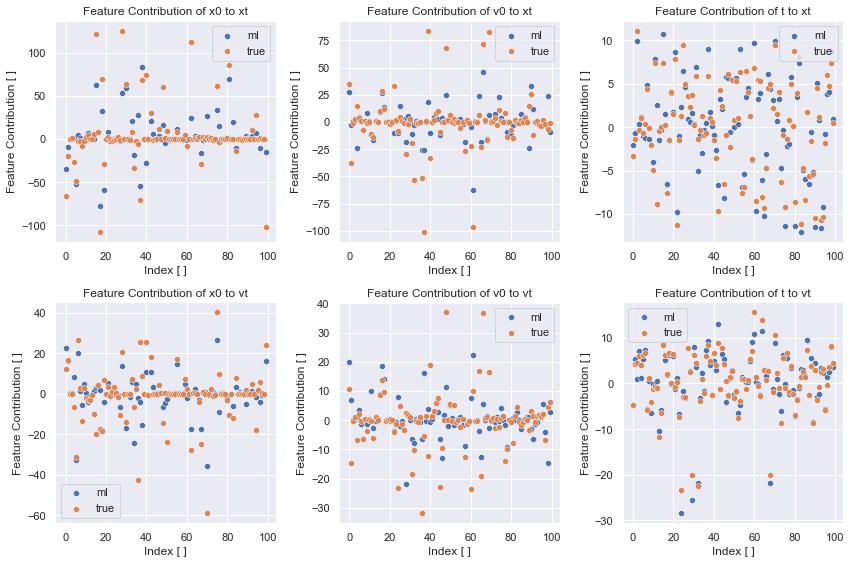

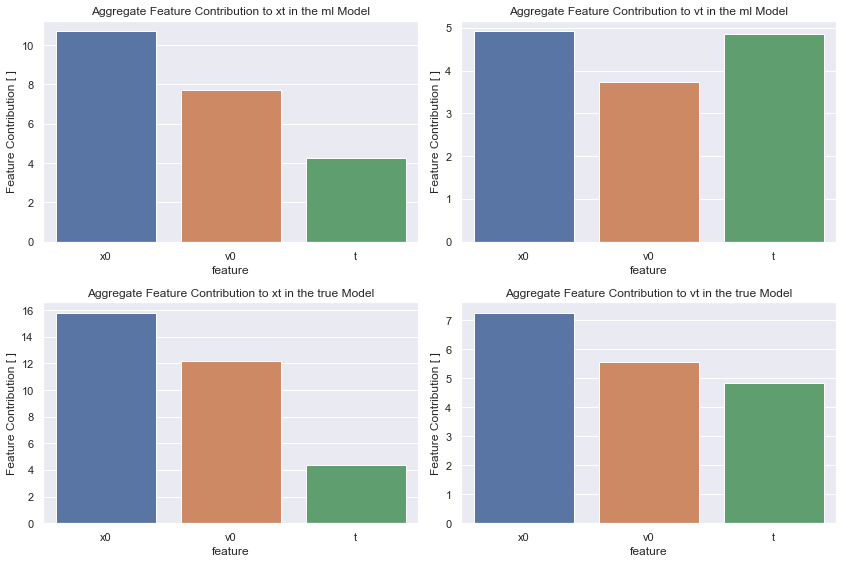

In [274]:
explainer_anal = wilke_explainer(models, X_train, X_test, y_test, explainer_type='analytic')

explainer_data = explainer_anal.eval_explainer()

explainer_anal.exp_plot()

explainer_agg = explainer_anal.aggregate()

explainer_anal.agg_plot()

In [183]:
true_model = TrueModel(scaler, X_test)

models = {'ml': model, 
         'true': true_model}

explainer = wilke_explainer(models, X_train, X_test, y_test, num_vals =4)

  0%|          | 0/4 [00:00<?, ?it/s]

[array([[-0.48715671, -0.21513467, -0.4518448 ],
       [ 0.07111302,  0.20616901,  0.01775114],
       [-0.29652456, -0.23852803, -0.48024332],
       [ 0.28365934,  0.40166616,  0.24561507]]), array([[ 0.17561603,  0.2146135 ,  0.30133073],
       [-0.07589605,  0.04685759, -0.22740764],
       [ 0.16154388,  0.18901683,  0.16425503],
       [-0.05117669, -0.03267923, -0.0281018 ]])]


  0%|          | 0/4 [00:00<?, ?it/s]

[array([[-0.46522703, -0.32356624, -0.4430234 ],
       [-0.15118251, -0.13698888,  0.07789654],
       [-0.28701181, -0.2912367 , -0.4477384 ],
       [ 0.31578928,  0.37891292,  0.32866516]]), array([[ 0.18347156,  0.21539027,  0.28075137],
       [-0.0995675 ,  0.00073483, -0.24400496],
       [ 0.18164681,  0.15232028,  0.10084202],
       [-0.05677801, -0.03385353, -0.0677799 ]])]


  0%|          | 0/4 [00:00<?, ?it/s]

[array([[ 0.27708378,  0.11010115,  0.11561089],
       [ 0.31791964,  0.24718443,  0.08356017],
       [-0.45389355, -0.2742453 , -0.51791675],
       [-0.3465751 , -0.2971786 , -0.24588084]]), array([[-0.02656175,  0.02760231, -0.28273946],
       [ 0.02184654,  0.12924251,  0.29382692],
       [ 0.18719856,  0.17240683,  0.24781111],
       [ 0.11728763,  0.11509283,  0.28413199]])]


  0%|          | 0/4 [00:00<?, ?it/s]

[array([[ 0.25404072,  0.06526303,  0.18649804],
       [ 0.27978528,  0.17550874,  0.07202368],
       [-0.50135436, -0.32254772, -0.48655189],
       [-0.32309069, -0.28279309, -0.19125457]]), array([[-0.05156462,  0.03999351, -0.32561729],
       [ 0.01005703,  0.12554007,  0.22469949],
       [ 0.2165593 ,  0.17848496,  0.21552022],
       [ 0.16858   ,  0.18325424,  0.32868429]])]


  0%|          | 0/4 [00:00<?, ?it/s]

[array([[-0.29609911, -0.5185664 , -0.26893989],
       [ 0.17902476,  0.22399218,  0.45259815],
       [ 0.09541565,  0.26436971,  0.32649227],
       [ 0.16822409,  0.24168601,  0.00221872]]), array([[-0.16913046, -0.16544013,  0.07864723],
       [ 0.16772954,  0.18042034, -0.10430559],
       [ 0.00631431, -0.02644813, -0.33579636],
       [ 0.07726642, -0.03294211, -0.09878951]])]


  0%|          | 0/4 [00:00<?, ?it/s]

[array([[-0.29109969, -0.52311199, -0.24102882],
       [ 0.17134138,  0.22115662,  0.47271967],
       [ 0.08688579,  0.26439532,  0.35766464],
       [ 0.1668981 ,  0.2921943 , -0.02467514]]), array([[-0.19019205, -0.19717509,  0.09371994],
       [ 0.16709809,  0.19360153, -0.07197825],
       [ 0.02144947, -0.02892661, -0.37073116],
       [ 0.06912677, -0.01923076, -0.16599547]])]


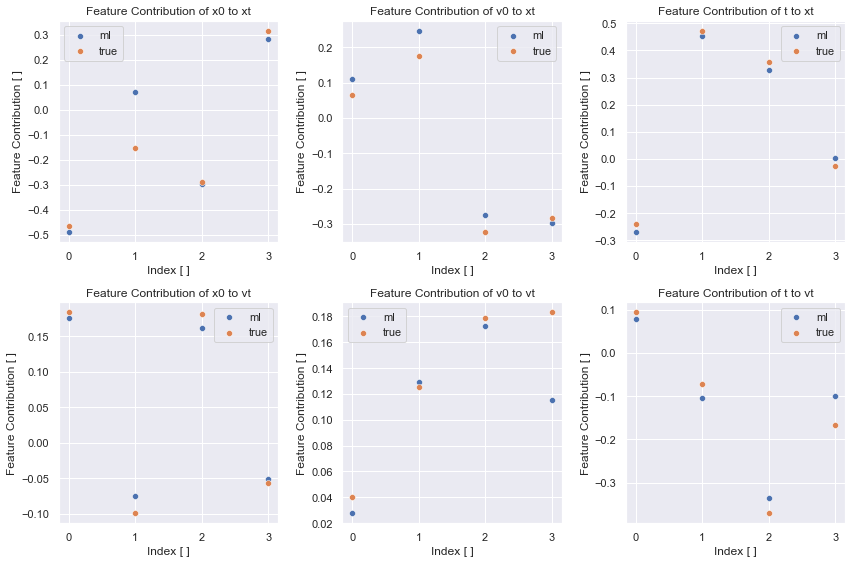

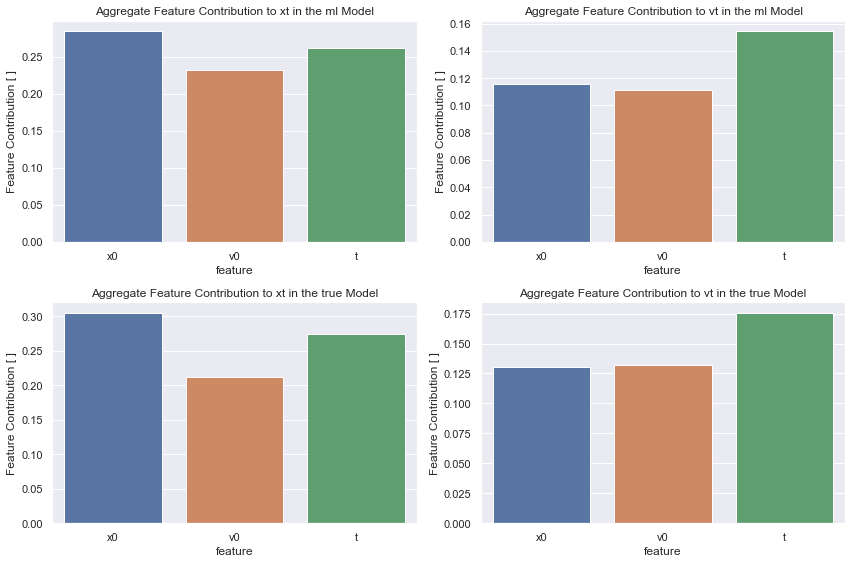

In [184]:
explainer_data = explainer.eval_explainer()

explainer.exp_plot()

explainer_agg = explainer.aggregate()

explainer.agg_plot()

## Lime

Using SHAP's LimeTabular for explainability

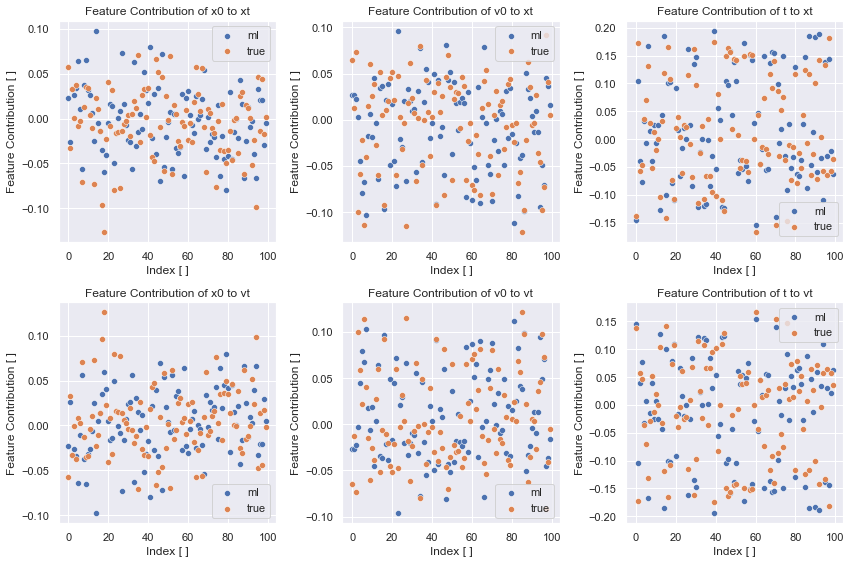

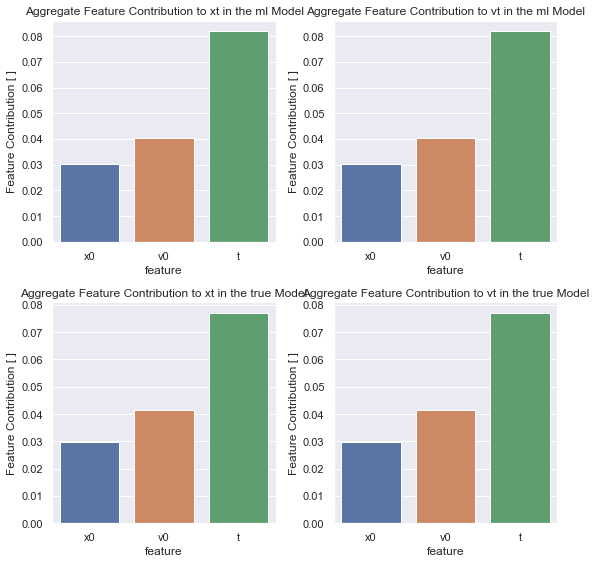

In [74]:
explainer = wilke_explainer(models, X_train, X_test, y_test, explainer_type='lime')

explainer_data = explainer.eval_explainer()

explainer.exp_plot()

explainer_agg = explainer.aggregate()

explainer.agg_plot()

## An Analytic Approach to Explaining Feature Importance

In order to evaluate the usefulness of SHAP in explaining feature importance we need to determine what we would expect the explainer to give us.

The initial approach to doing this will be to take the gradient in each feature direction (x0,v0,t) at each point.

Since we cannot calculate the gradient analytically this will be done numerically.

To do so we take a point and calculate how much it shifts based on changing the input parameters:

$f(x_0+\delta,v_0,t) = (x,v),\quad f(x_0-\delta,v_0,t) = (x',v')  ,\quad \frac{df}{dx_0} = \frac{|(x',v')-(x,v)|}{\delta}$

In [78]:
shap.KernelExplainer

0        0.535233
1        0.910379
2        2.424450
3        0.301963
4        0.686811
           ...   
99995    2.650856
99996    0.506197
99997    1.800192
99998    3.559158
99999    3.436259
Name: x0, Length: 100000, dtype: float64

In [269]:
class AnalyticExplainer():
    def __init__(self, f, features, labels,  h=0.01):
        self.f = f
        self.features = features
        self.labels = labels
        self.h = h
        
    def feature_att(self, X):
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            if first_run:
                self.__atts = grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                        
        return self.__atts
    
    def gradient(self, X_val, feature):
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    """    
    def feature_att_outdated(self, X):
        first_run=True
        self.X = X
        for i, __feature in enumerate(self.features):
            for j, __label in enumerate(self.labels):
                for k in range(self.X.shape[0]):
                    x0, v0, t, *other = self.X.iloc[k:k+1].values[0]
                    multi_index = [[__feature], [__label], [x0], [v0], [t]]
                    if first_run:
                        self.gradients = pd.DataFrame(self.gradient(self.X.iloc[k:k+1], __feature),
                                                     columns = ['dxt', 'dvt'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'label', 'x0', 'v0','t')))
                    else:
                        self.gradients = self.gradients.append(pd.DataFrame(
                            self.gradient(self.X.iloc[k:k+1], __feature, __label),
                                                     columns = ['dxt', 'dvt'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'label', 'x0', 'v0','t'))))
                    first_run = False
                        
        return self.gradients
    """           


In [270]:
test = AnalyticExplainer(true_model.predict, X_test.columns, y_test.columns)

In [271]:
test.feature_att(X_test.iloc[:100])

[array([[ 1.13617395e+00, -5.64343779e-02, -2.05709504e+00],
        [-1.00604424e+02,  8.21429386e+01,  6.35259791e+00],
        [ 1.30833821e+01,  3.77638259e+01,  9.37563592e+00],
        [ 5.72051248e+00,  9.33513692e+01, -8.50931087e+00],
        [-7.78218819e+01,  3.25279023e+01,  1.82692837e+00],
        [ 4.63926066e-01, -3.85845450e-01, -6.62869388e+00],
        [-1.02189103e+01, -4.70823797e+00,  9.70108296e+00],
        [-1.18517424e-01, -1.06415337e-01, -6.33296428e+00],
        [-1.02714299e-01,  1.41145052e-01, -1.07168584e+01],
        [ 3.28566031e-01, -1.73205343e-01, -8.14743903e+00],
        [ 1.14138637e-01, -2.28465545e-02,  3.49979382e+00],
        [ 4.32904328e+00,  7.88987054e-02,  1.21294437e+01],
        [ 1.18794712e+02,  1.96565274e-01,  1.40004951e+00],
        [ 2.31136845e-01,  3.17583909e-01,  1.28925167e+01],
        [-3.80844539e+00, -1.72900774e+00, -9.10938886e+00],
        [ 6.00015314e-01,  3.89800786e-03, -6.78285014e+00],
        [ 7.88128166e-01

In [218]:
np.vstack((test.gradient(X_test.iloc[k:k+3], 'x0', 'xt')[:,0],test.gradient(X_test.iloc[k:k+3], 'v0', 'xt')[:,0])).transpose()

array([[118.79471154,   0.19656527],
       [  0.23113684,   0.31758391],
       [ -3.80844539,  -1.72900774]])

In [ ]:
    def feature_att(self, X):
        first_run = True
        for i,__label in enumerate(self.y_test.columns):
            grads = test.gradient(X_test.iloc[:10], X_test.columns[0])[:,i]
            for __feat in X_test.columns[1:]:
                grads = np.vstack((grads,test.gradient(X_test.iloc[:10], __feat)[:,i]))
                if first_run:
                    __atts = grads.transpose()
                    first_run = False
                else:
                    __atts = [__atts, grads.transpose()]
                        
        return self.gradients

In [ ]:
[array([[-0.48715671, -0.21513467, -0.4518448 ],
       [ 0.07111302,  0.20616901,  0.01775114],
       [-0.29652456, -0.23852803, -0.48024332],
       [ 0.28365934,  0.40166616,  0.24561507]]), array([[ 0.17561603,  0.2146135 ,  0.30133073],
       [-0.07589605,  0.04685759, -0.22740764],
       [ 0.16154388,  0.18901683,  0.16425503],
       [-0.05117669, -0.03267923, -0.0281018 ]])]

In [188]:
[test.feature_att(X_test.iloc[:10,:]).values[:,0], test.feature_att(X_test.iloc[:10,:]).values[:,1]]

[array([ 1.13617395e+00, -1.00604424e+02,  1.30833821e+01,  5.72051248e+00,
        -7.78218819e+01,  4.63926066e-01, -1.02189103e+01, -1.18517424e-01,
        -1.02714299e-01,  3.28566031e-01,  1.13617395e+00, -1.00604424e+02,
         1.30833821e+01,  5.72051248e+00, -7.78218819e+01,  4.63926066e-01,
        -1.02189103e+01, -1.18517424e-01, -1.02714299e-01,  3.28566031e-01,
        -5.64343779e-02,  8.21429386e+01,  3.77638259e+01,  9.33513692e+01,
         3.25279023e+01, -3.85845450e-01, -4.70823797e+00, -1.06415337e-01,
         1.41145052e-01, -1.73205343e-01, -5.64343779e-02,  8.21429386e+01,
         3.77638259e+01,  9.33513692e+01,  3.25279023e+01, -3.85845450e-01,
        -4.70823797e+00, -1.06415337e-01,  1.41145052e-01, -1.73205343e-01,
        -2.05709504e+00,  6.35259791e+00,  9.37563592e+00, -8.50931087e+00,
         1.82692837e+00, -6.62869388e+00,  9.70108296e+00, -6.33296428e+00,
        -1.07168584e+01, -8.14743903e+00, -2.05709504e+00,  6.35259791e+00,
         9.3

In [171]:
X_test.iloc[:10,:]

,x0,v0,t
0,-1.464767,-0.156468,-0.529506
1,-1.089621,0.546080,-0.127674
2,0.424450,0.307538,-0.183099
3,-1.698037,-0.680542,-0.522578
4,-1.313189,0.320245,-0.827417
5,-0.679337,-0.311083,0.087099
6,0.259653,-0.966285,-1.347028
7,-0.013089,-0.008905,1.708285
8,0.946284,-0.082922,0.592853
9,0.847942,0.234213,0.710632


In [ ]:
self.gradients = pd.DataFrame(self.gradient(self.f.predict, X.iloc[(k-1):k], __feature, __label),
                                                     columns = ['dxt', 'dvt'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'label', 'x0', 'v0','t')))

In [ ]:
self.gradients = self.agg_vals.append(pd.DataFrame(self.agg_func(
                            self.feature_attributions.xs((__feature,
                                                          __contribution,
                                                          __model), 
                                                         level=('feature', 'contribution', 'model'))[__feature].values),
                                                     columns = ['contrib'], 
                                                     index = pd.MultiIndex.from_arrays(multi_index, 
                                                                        names=('feature', 'contribution', 'model'))))

In [112]:
def gradient(f, X, feature, label):
        X_prime_plus = X.copy()
        X_prime_minus = X.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + 1
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - 1
        
        grad = (f(X_prime_plus) - f(X_prime_minus))/(2*1)
        
        return grad

In [136]:
x0, v0, t, *other = X_test.iloc[(k-1):k].values[0]

In [138]:
other

[]

In [118]:
X_test.iloc[:10,:].shape

(10, 3)

In [122]:
k = 11

In [123]:
['x0', 't', X_test.iloc[(k-1):k], gradient(true_model.predict, X_test.iloc[(k-1):k], 'x0', 'xt')]

['x0',
 't',
           x0       v0         t
 10  1.208571 -0.36723 -1.319315,
 array([[-0.11137892, -0.44389827]])]

In [129]:
a, b, c, *d = X_test.iloc[(k-1):k]

In [130]:
a

'x0'

In [128]:
X_test.iloc[(k-1):k].values

array([[ 1.20857133, -0.36723022, -1.31931502]])

In [ ]:
def num_grad(f, X, y, delta=0.01):
    """
        Numerical Gradient Calculation by Perturbing the 
        Inputs using a Central Finite Difference Method

        df/dx0 = |f(x0+delta,v0,t)-f(x0-delta,v0,t)|/(2*delta)

        Input
        ----------
        f : function to differentiate
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        delta : float, perturbation

        Returns
        ----------
        [df/dx0,df/dv0] : Tuple, Derivatives of f by 
                    starting position and velocity

    """
    for i, __feature in X.columns:
        for j, __label in y.columns:
            deriv[i,j] = 
            
    x01df = pd.DataFrame(np.array([X['x0']+delta, X['v0'],X['t']]), columns=X.columns)
    x02df = pd.DataFrame(np.array([X['x0']-delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    v01df = pd.DataFrame(np.array([X['x0'], X['v0']+delta,X['t']]), columns=['x0','v0','t'])
    v02df = pd.DataFrame(np.array([X['x0'], X['v0']-delta,X['t']]), columns=['x0','v0','t'])
    
    dx0 = (f(x01df) - f(x02df))/(2*delta)
    
    dv0 = (f(v01df) - f(v02df))/(2*delta)
    
    return pd.DataFrame(np.array([dx0, dv0]), columns=['dx0', 'dv0'])

In [ ]:
def num_grad(f, X, delta=0.01):
    """
        Numerical Gradient Calculation by Perturbing the 
        Inputs using a Central Finite Difference Method

        df/dx0 = |f(x0+delta,v0,t)-f(x0-delta,v0,t)|/(2*delta)

        Input
        ----------
        f : function to differentiate
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        delta : float, perturbation

        Returns
        ----------
        [df/dx0,df/dv0] : Tuple, Derivatives of f by 
                    starting position and velocity

    """
    
    x01df = pd.DataFrame(np.array([X['x0']+delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    x02df = pd.DataFrame(np.array([X['x0']-delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    v01df = pd.DataFrame(np.array([X['x0'], X['v0']+delta,X['t']]), columns=['x0','v0','t'])
    v02df = pd.DataFrame(np.array([X['x0'], X['v0']-delta,X['t']]), columns=['x0','v0','t'])
    
    dx0 = (f(x01df) - f(x02df))/(2*delta)
    
    dv0 = (f(v01df) - f(v02df))/(2*delta)
    
    return pd.DataFrame(np.array([dx0, dv0]), columns=['dx0', 'dv0'])

In [ ]:
num_grad(true_model.predict, X, delta=0.01)

Notes:

Plan: 
    Finish gradient calc
    Plots:
            xt against x0, t, v0. individually. same for vt
            feature importance with x0 ordered etc
            